<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/DEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
# import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

In [ ]:
# !pip install GitPython
# from git import Repo
# # !git clone https://github.com/MariiaKalinina/Elasticity.git
# !git clone https://github.com/fvizeus/PyDEM.git DEM

### Working code
1) https://github.com/yujiaxin666/rockphypy/blob/c17275a3de7cb12b242a7fcf6e98ad7acade11ac/rockphypy/Fluid.py

2) https://github.com/fvizeus/PyDEM/tree/master

### Input data: elastic

In [ ]:
def bulk_mdl(p, vp, vs):

    K = list(map(lambda x, y, z: x * (y**2 - 4/3*z**2), p, vp, vs))
    μ = list(map(lambda x, z: x * z**2, p, vs))
    return K[0], μ[0]

In [ ]:
### Calcite. (Известняк состоит преимущественно из кальцита)
K_calcite, mu_calcite = bulk_mdl([2.71], [6.54], [3.35])
p_calcite = 2.71
### Dolomite
K_dolomite, mu_dolomite = bulk_mdl([2.86], [6.40], [3.46])

In [ ]:
K_oil, Mu_oil, p_oil = 0.26, 10**-12, 1.04
K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air

## Elastic properties

### VHR borders

In [ ]:
def VRH (K, μ, f):

    K_voit = (f[0]*K[0]) + (f[1]*K[1])

    K_ross = (f[0]/K[0] + f[1]/K[1])**-1

    K_hill = np.mean([K_voit, K_ross])

    μ_voit = (f[0]*μ[0]) + (f[1]*μ[1])

    μ_ross = (f[0]/μ[0] + f[1]/μ[1])**-1

    μ_hill = np.mean([μ_voit, μ_ross])

    return K_voit, K_ross, K_hill, μ_voit, μ_ross, μ_hill

### HS borders

In [ ]:
def HS_borders(K, μ, f):

  K_up = K[0] + (f[1]/((K[1]-K[0])**-1 + f[0]*(K[0]+4/3*μ[0])**-1))
  K_lo = K[1] + (f[0]/((K[0]-K[1])**-1 + f[1]*(K[1]+4/3*μ[1])**-1))
  K_av = np.mean([K_up, K_lo])

  μ_up = μ[0] + ((f[1])/((μ[1]-μ[0])**-1 + 2*f[0]*(K[0]+2*μ[0])/(5*μ[0]*(K[0]+4/3*μ[0]))))
  μ_lo = μ[1] + ((f[0])/((μ[0]-μ[1])**-1 + 2*f[1]*(K[1]+2*μ[1])/(5*μ[1]*(K[1]+4/3*μ[1]))))
  μ_av = np.mean([μ_up, μ_lo])

  return K_up, K_lo, K_av, μ_up, μ_lo, μ_av

In [ ]:
"""
From Berryman 1980
"""

import numpy as np
from scipy.optimize import fsolve

def theta(alpha):
    return alpha*(np.arccos(alpha) - alpha*np.sqrt(1.0 - alpha*alpha))/(1.0 - alpha*alpha)**(3.0/2.0)

def f(alpha, theta):
    return alpha*alpha*(3.0*theta - 2.0)/(1.0 - alpha*alpha)

def PQ(A, B, R, theta, f):
    F1 = 1.0 + A*(1.5*(f + theta) - R*(1.5*f + 2.5*theta - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + theta) - R*(1.5*f + 2.5*theta)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + theta - R*(f - theta + 2.0*theta*theta))
    F3 = 1.0 + A*(1.0 - f - 1.5*theta + R*(f + theta))
    F4 = 1.0 + (A/4.0)*(f + 3.0*theta - R*(f - theta))
    F5 = A*(-f + R*(f + theta - 4.0/3.0)) + B*theta*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + theta)) + B*(1.0 - theta)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*theta - R*(3.0*f + 5.0*theta)) + B*theta*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (theta/2.0)*(5.0*R - 3.0)) + B*(1.0 - theta)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*theta) + B*theta*(3.0 - 4.0*R)

    P = 3.0*F1/F2
#     P = F1/F2
    Q = 2.0/F3 + 1.0/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    return P, Q

def KG(Km, Gm, Ki, Gi, ci, theta, f):
    A = Gi/Gm - 1.0
    B = (Ki/Km - Gi/Gm)/3.0
    R = Gm/(Km + (4.0/3.0)*Gm)
    Fm = (Gm/6.0)*(9.0*Km + 8.0*Gm)/(Km + 2.0*Gm)

    P, Q = PQ(A, B, R, theta, f)

    K = Km - (Km + (4.0/3.0)*Gm)*ci*(Km - Ki)*P/3.0/(Km + (4.0/3.0)*Gm + ci*(Km - Ki)*P/3.0)
    G = Gm - (Gm + Fm)*ci*(Gm - Gi)*Q/5.0/(Gm + Fm + ci*(Gm - Gi)*Q/5.0)

    return K, G

def DEM(Km, Gm, Ki, Gi, alphai, phii, phi0=0.0, r=1000, phitol=1.0E-10, gamma=0.01):
    phi = np.sum(phii)
    fraci = phii/np.sum(phi)
    ci = fraci*alphai/r
    n = int(np.ceil((np.log(1.0-phi)-np.log(1.0-phi0))/np.sum(np.log(1.0-ci))))
    m = len(alphai)

    def func(r):
        f = np.empty(m)
        f[0] = np.log(alphai[0]/r[0]) + np.log(1.0 - phi0/phi) - np.log(1 - ((1.0 - phi)/(1.0 - phi0))**(1.0/n))
        for j in range(1, m):
            f[j] = f[j-1] + np.log(alphai[j]/r[j]) + np.log(r[j-1]/alphai[j-1] - fraci[j-1])
        return f

    def fprime(r):
        jac = np.diag(-1.0/r)
        for j in range(0, m-1):
            jac[j+1:, j] = -1.0/r[j] + 1.0/(r[j] - fraci[j]*alphai[j])

        return jac

    r0 = r*np.ones(m)

    ri = fsolve(func, r0, fprime=fprime, factor=0.1)

    ci = fraci*alphai/ri

    thetai = theta(alphai)
    fi = f(alphai, thetai)

    K = np.empty(n)
    G = np.empty(n)
    phi = np.empty(n)

    K_ = Km
    G_ = Gm
    phi_ = phi0

    for i in range(n):
        dphi = ci[0]*(1.0 - phi_)
        K_, G_ = KG(K_, G_, Ki[0], Gi[0], ci[0], thetai[0], fi[0])
        phi_ += dphi
        for j in range(1, m):
            dphi *= ci[j]*(1.0 - ci[j-1])/ci[j-1]
            K_, G_ = KG(K_, G_, Ki[j], Gi[j], ci[j], thetai[j], fi[j])
            phi_ += dphi
        K[i] = K_
        G[i] = G_
        phi[i] = phi_

    return K, G, phi

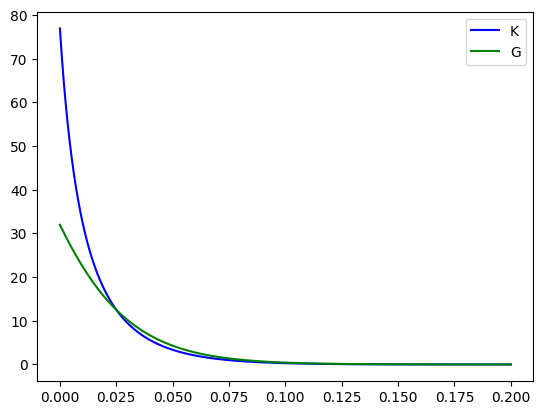

In [ ]:
# Matrix properties
Km = K_calcite # GPa
Gm = mu_calcite # GPa
rhom = 2.71 # g/cm3

# Fluid properties
Kf = 2.2 # GPa
rhof = 1.0 # g/cm3


# Porosity
phimax = 0.2

# Inclusion properties
# In this example a mixture of three inclusion types are used:
# - 30% of 0.02 aspect ratio
# - 50% of 0.15 aspect ratio
# - 20% of 0.80 aspect ratio
# alphas = np.array([0.01, 0.15, 0.8])
# volumes = np.array([0.3, 0.5, 0.2])*phimax

alphas = np.array([0.01])
volumes = np.array([1])*phimax

# Dry inclusions
Kis = np.zeros(len(alphas), dtype=float)
Gis = np.zeros(len(alphas), dtype=float)

# The DEM function returns the bulk and shear moduli along with the porosity array to match them.
# The porosity array is not regularly spaced. If you need so, you should reinterpolate.
K, G, phi = DEM(Km, Gm, Kis, Gis, alphas, volumes)

rho = (1.0 - phi)*rhom + phi*rhof
# Ks = Gassmann.Ks(K, Km, Kf, phi)

# Vp = np.sqrt((Ks + 4.0*G/3.0)/rho)
# Vs = np.sqrt(G/rho)

plt.plot(phi, K, 'b', label='K')
plt.plot(phi, G, 'g', label='G')

plt.legend()

plt.show()

### Main DEM

In [ ]:
from scipy.optimize import fsolve
from scipy.integrate import odeint

In [ ]:
def PQ(Km,Gm, Ki,Gi, alpha):
    """compute geometric strain concentration factors P and Q for prolate and oblate spheroids according to Berymann (1980). See also PQ_vectorize

    Parameters
    ----------
    Km : float
        Bulk modulus of matrix phase
    Gm : float
        Shear modulus of matrix phase
    Ki : float
        Bulk modulus of inclusion phase
    Gi : float
        Shear modulus of inclusion phase
    alpha : float
        aspect ratio of the inclusion. Note that α <1 for oblate spheroids and α > 1 for prolate spheroids

    Returns
    -------
    float
        P,Q (unitless): geometric strain concentration factors
    """

    if alpha==1:
        P= (Km+4*Gm/3)/(Ki+4*Gm/3)
        kesai= Gm/6 *(9*Km+8*Gm)/(Km+2*Gm)
        Q= (Gm+kesai)/(Gi+kesai)

    else:

        if alpha<1:
            theta= alpha/(1.0 - alpha**2)**(3.0/2.0) * (np.arccos(alpha) - alpha*np.sqrt(1.0 - alpha**2))
        else:
            theta= alpha/(alpha**2-1)**(3.0/2.0) * ( alpha*(alpha**2-1)**0.5 -np.cosh(alpha)**-1)
        f= alpha**2*(3.0*theta - 2.0)/(1.0 - alpha**2)
        A = Gi/Gm - 1.0
        B = (Ki/Km - Gi/Gm)/3.0
        R = Gm/(Km + (4.0/3.0)*Gm) #
        F1 = 1.0 + A*(1.5*(f + theta) - R*(1.5*f + 2.5*theta - 4.0/3.0))
        F2 = 1.0 + A*(1.0 + 1.5*(f + theta) - R*(1.5*f + 2.5*theta)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + theta - R*(f - theta +
        2.0*theta**2))
        F3 = 1.0 + A*(1.0 - f - 1.5*theta + R*(f + theta))
        F4 = 1.0 + (A/4.0)*(f + 3.0*theta - R*(f - theta))
        F5 = A*(-f + R*(f + theta - 4.0/3.0)) + B*theta*(3.0 - 4.0*R)
        F6 = 1.0 + A*(1.0 + f - R*(f + theta)) + B*(1.0 - theta)*(3.0 - 4.0*R)
        F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*theta - R*(3.0*f + 5.0*theta)) + B*theta*(3.0 - 4.0*R)
        F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (theta/2.0)*(5.0*R - 3.0)) + B*(1.0 - theta)*(3.0 - 4.0*R)
        F9 = A*((R - 1.0)*f - R*theta) + B*theta*(3.0 - 4.0*R)
        Tiijj = 3*F1/F2
        Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
        P = Tiijj/3
        Q = (Tijij - P)/5
    return P, Q

def DEM(y,t, params):
    '''
    ODE solver tutorial: https://physics.nyu.edu/pine/pymanual/html/chap9/chap9_scipy.html.
    '''
    K_eff,G_eff=y  # unpack current values of y
    Gi,Ki,alpha = params # unpack parameters
    P, Q= PQ(G_eff,K_eff,Gi,Ki, alpha)
    derivs = [1/(1-t) * (Ki-K_eff) * P,  1/(1-t) * Gi-G_eff * Q]
    return derivs


def Berryman_DEM(Km,Gm, Ki, Gi, alpha,phi):
    """Compute elastic moduli of two-phase composites by incrementally adding inclusions of one phase (phase 2) to the matrix phase using Berryman DEM theory

    Parameters
    ----------
    Km : float
        host mineral bulk modulus
    Gm : float
        host mineral shear modulus
    Ki : float
        bulk modulus of inclusion
    Gi : float
        shear modulus of inclusion
    alpha : float
        aspect ratio of the inclusion phase
    phi : float
        desired fraction occupied by the inclusion
    """
    #Bundle parameters for ODE solver
    params = [Gi,Ki,alpha]
    #Bundle initial conditions for ODE solver
    y0 = [Km,Gm]
    # Make time array for solution
    tStop = phi
    tInc = 0.1
    t = np.arange(0, tStop+tInc, tInc)
    psoln = odeint(DEM, y0, t, args=(params,))
    K_dry_dem=psoln[:,0]
    G_dry_dem=psoln[:,1]
    return K_dry_dem, G_dry_dem,t

In [ ]:
Km = K_calcite
Gm = mu_calcite

Ki, Gi = K_air, Mu_air
# Ki, Gi = K_water, Mu_water

alpha = 0.01
phi=0.9

### K modulus plot

(0.0, 0.2)

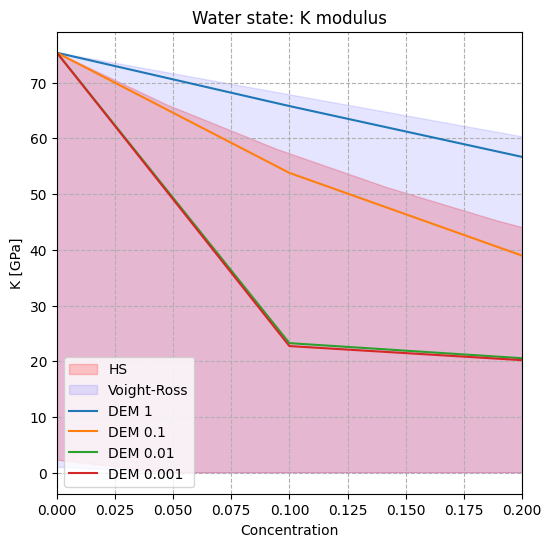

In [ ]:
K_matrix, K_fluid = Km, Ki
Mu_matrix, Mu_fluid = Gm, Gi

porosity = np.linspace(0.000001, phi, 20, endpoint=True)
K_up_value, K_lo_value, K_av_value = [], [], []
K_voigt, K_ross = [],[]


for phi in porosity:
  K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
  K_up, K_lo, K_av, _, _, _ = HS_borders(K, μ, f)
  K_up_value.append(K_up)
  K_lo_value.append(K_lo)
  K_av_value.append(K_av)

  K_up, K_lo, K_av, _, _, _ = VRH(K, μ, f)
  K_voigt.append(K_up)
  K_ross.append(K_lo)


plt.figure(figsize=(6,6))
plt.xlabel('Concentration')
plt.ylabel('K [GPa]')
plt.title('Water state: K modulus')

#Borders
plt.fill_between(porosity, K_up_value, K_lo_value, color='r', alpha=.2, label='HS')
plt.fill_between(porosity, K_voigt, K_ross, color='b', alpha=.1, label='Voight-Ross')

table = pd.DataFrame()
ar_list = [1, 0.1, 0.01, 0.001]
 #DEM
for ar_inclusion in ar_list:

  K, mu, por = Berryman_DEM(Km, Gm, Ki, Gi, ar_inclusion, phi)
  plt.plot(por, K, label=f'DEM {ar_inclusion}')
  table['Concentration'] = por
  table[f'{ar_inclusion}'] = K


plt.legend(loc='best')
plt.grid(ls='--')
plt.xlim(0, 0.2)

### Mu modulus plot

(0.0, 0.2)

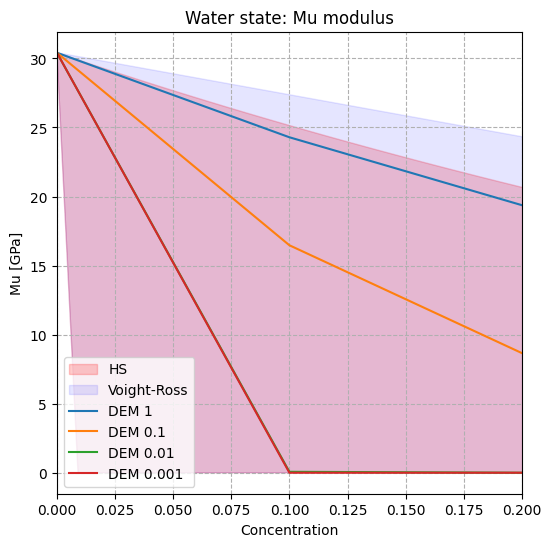

In [ ]:
K_matrix, K_fluid = Km, Ki
Mu_matrix, Mu_fluid = Gm, Gi

porosity = np.linspace(0, phi, 100, endpoint=True)
K_up_value, K_lo_value, K_av_value = [], [], []

K_voigt, K_ross = [],[]


for phi in porosity:
  K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
  _, _, _, mu_up, mu_lo, mu_av = HS_borders(K, μ, f)
  K_up_value.append(mu_up)
  K_lo_value.append(mu_lo)
  K_av_value.append(mu_av)


  _, _, _, mu_up, mu_lo, mu_av  = VRH(K, μ, f)
  K_voigt.append(mu_up)
  K_ross.append(mu_lo)



plt.figure(figsize=(6,6))
plt.xlabel('Concentration')
plt.ylabel('Mu [GPa]')
plt.title('Water state: Mu modulus')

#Borders
plt.fill_between(porosity, K_up_value, K_lo_value, color='r', alpha=.2, label='HS')
plt.fill_between(porosity, K_voigt, K_ross, color='b', alpha=.1, label='Voight-Ross')


table = pd.DataFrame()
ar_list = [1, 0.1, 0.01, 0.001]
 #DEM
for ar_inclusion in ar_list:

  K, mu, por = Berryman_DEM(Km, Gm, Ki, Gi, ar_inclusion,phi)
  plt.plot(por, mu, label=f'DEM {ar_inclusion}')
  table['Concentration'] = por
  table[f'{ar_inclusion}'] = mu


plt.legend(loc='best')
plt.grid(ls='--')
plt.xlim(0, 0.2)

## Transport properties

### DEM

In [ ]:
def tau_transport(Lm,Li,alpha):
    """compute geometric strain concentration factors P and Q for prolate and oblate spheroids according to Berymann (1980). See also PQ_vectorize

    Parameters
    ----------
    Km : float
        Bulk modulus of matrix phase
    Gm : float
        Shear modulus of matrix phase
    Ki : float
        Bulk modulus of inclusion phase
    Gi : float
        Shear modulus of inclusion phase
    alpha : float
        aspect ratio of the inclusion. Note that α <1 for oblate spheroids and α > 1 for prolate spheroids

    Returns
    -------
    float
        P,Q (unitless): geometric strain concentration factors
    """

#     if alpha==1:
#         f3 = 1/3
#         f1 = f2 = f3

#     else:

#         if alpha<1:
#             theta= alpha/(1.0 - alpha**2)**(3.0/2.0) * (np.arccos(alpha) - alpha*np.sqrt(1.0 - alpha**2))
#         else:
#             theta= alpha/(alpha**2-1)**(3.0/2.0) * ( alpha*(alpha**2-1)**0.5 -np.cosh(alpha)**-1)
#         f3 = alpha**2*(3.0*theta - 2.0)/(1.0 - alpha**2)
# #         tau = 1/9 * (4/(Lm+Li+f*(Lm - Li)) + 1/(Lm - f*(Lm - Li)))
#         f1=f2 = (1-f3)/2
#         print(f1, f2, f3)


    if alpha < 1:
        t1 = alpha ** 2
        t2 = 1 / t1
        t4 = np.sqrt(t2-1)
        t5 = np.arctan(t4)
        t8 = t4 ** 2

        f3 = t2 * (t4-t5) / t8 / t4
        f2 = f1 = (1-f3)/2

    elif alpha > 1:
        t1 = alpha ** 2
        t2 = 1 / t1
        t4 = np.sqrt(1-t2)
        t6 = np.log(1+t4)
        t9 = np.log(1-t4)
        t13 = t4 ** 2
        f3 = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
        f2 = f1 = (1-f3)/2

    elif alpha == 1:
        f3 = 1 / 3
        f1 = f2 = f3

#     print(f1, f2, f3)


#     tau = 1/9 * ((2*(1+(Li/Lm - 1)*f1)**-1 + (1+(Li/Lm - 1)*f3))**-1)
    tau = 1/9 * (2*(1-f2)**-1 + (1-f3)**-1)
#     tau1 = (f1*Li + (1-f1)*Lm)**-1
#     tau3 = (f3*Li + (1-f3)*Lm)**-1
#     tau = 1/9 * (2*tau1 + tau3)


    return tau

def DEM(y,t,params):

    L_eff = y  # unpack current values of y
    Lm, Li, alpha = params # unpack parameters
    tau = tau_transport(Lm, Li, alpha)
    derivs = ((Li - L_eff)*tau)/(1-t)
    return derivs


def Berryman_DEM_transport(Lm,Li,alpha,phi):

    #Bundle parameters for ODE solver
    params = [Lm, Li,alpha]
    #Bundle initial conditions for ODE solver
    y0 = Lm
    # Make time array for solution
    tStop = phi
    tInc = 0.001
    t = np.arange(0, tStop+tInc, tInc)
    L_eff = odeint(DEM, y0, t, args=(params,))
#     L_dry_dem=psoln[:,0]
    return L_eff

### GSA Self-consistent

In [ ]:
def effective_tc(conc, alpha_shape, lam):

    x0=0

    phi = conc

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))
    L0 = lam[0]

    def raschet(L0):

        parall_comp, perpen_comp = [], []
#         print('Тело сравнения', L0)

        for i, j, f in zip(phi, lam, depolar_F):

#             print('Каждая комопонента')
#             print(i, j, f)

            termc_3 = i * j / (L0 * (1-f)+j * f)
            termz_3 = i / (L0 * (1-f)+j * f)

            termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
            termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

            termc_all = (termc_3+2 * termc_12) / 3
            termz_all = (termz_3+2 * termz_12) / 3

            t16 = termc_all # числитель
            t15 = termz_all # Знаменатель

#             print('ТС матрицы', j)
#             print('t16:' , t16)
#             print('t15:' , t15)

            parall_comp.append(t16)  # числитель формулы (матрица, флюид)
            perpen_comp.append(t15)  # знаменатель формулы (матрица, флюид)

#         print('Параллельный компоненты ТС', parall_comp)
#         print('Перпендикулярные компоненты ТС', perpen_comp)

        L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
#         print('TC eff: ', L_eff, end='\n\n')
        return L_eff

    x0 = L0
    L0 = raschet(x0)
    it_f = 1
    while abs(x0-L0) >= 10 **-6:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1

#     print('Количество итераций: ', it_f, end='\n\n')
    return L0

#     print('Эффективное значение TC_eff:', raschet(L0))

### Hashin-Strikman

In [ ]:
def Upper_Hashin_Strikman(phi, lam):
    L0 = max(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    # print('TC Upper Hashin-Strikman:', L_eff)
    return L_eff


def Lower_Hashin_Strikman(phi, lam):
    L0 = min(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    return L_eff

def Average_Hashin_Strikman(phi, lam):
    return np.mean([Lower_Hashin_Strikman(phi, lam), Upper_Hashin_Strikman(phi, lam)])

### Winner borders

In [ ]:
def upper_winner(phi, lam):
    lst = []
    for i, j in zip(phi, lam):
        sum = i * j
        lst.append(sum)

    Up_W = 0
    for i in lst:
        Up_W += i
#     print('TC Upper Wiener: ', Up_W)
    return Up_W


def lower_winner(phi, lam):
    lst = []
    for i, j in zip(phi, lam):
        sum = i / j
        lst.append(sum)

    Lo_W = 0
    for i in lst:
        Lo_W += i
    Lo_W **=-1
#     print('TC Lower Wiener: ', Lo_W)
    return Lo_W

def Average_Winner(phi, lam):
    return np.mean([upper_winner(phi, lam), lower_winner(phi, lam)])


In [ ]:
Lm, Li, phi = 3, 0.6, 1

In [ ]:
dem_1, dem_01, dem_001, dem_0001 = Berryman_DEM_transport(Lm, Li, 1, phi), Berryman_DEM_transport(Lm, Li, 0.1, phi),\
 Berryman_DEM_transport(Lm, Li,0.01,phi), Berryman_DEM_transport(Lm, Li,0.001,phi)

tStop = phi
tInc = 0.001
t = np.arange(0, tStop+tInc, tInc)
lam_eff_1 = []
lam_eff_001 = []

hs_up, hs_down = [], []
win_up, win_down = [], []

for i in t:
    lam_eff_1.append(effective_tc([1-i, i], [1, 1], [Lm, Li,]))
    lam_eff_001.append(effective_tc([1-i, i], [1, 0.001], [Lm, Li,]))

    hs_up.append(Upper_Hashin_Strikman([1-i, i], [Lm, Li,]))
    hs_down.append(Lower_Hashin_Strikman([1-i, i], [Lm, Li,]))

    win_up.append(upper_winner([1-i, i], [Lm, Li,]))
    win_down.append(lower_winner([1-i, i], [Lm, Li,]))

<ipython-input-254-6586a2eb0c9b>:80: RuntimeWarning: divide by zero encountered in divide
  derivs = ((Li - L_eff)*tau)/(1-t)


### Visualization (porosity - TC)

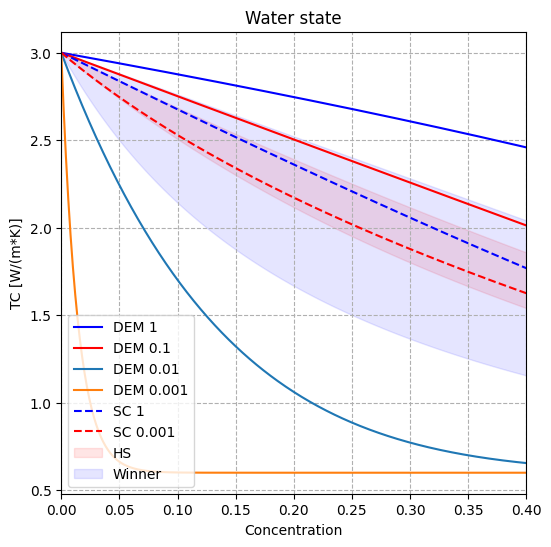

In [ ]:
tStop = phi
tInc = 0.001
t = np.arange(0, tStop+tInc, tInc)

plt.figure(figsize=(6,6))

plt.plot(t, dem_1, '-b', label='DEM 1')
plt.plot(t, dem_01, '-r', label='DEM 0.1')
plt.plot(t, dem_001, label='DEM 0.01')
plt.plot(t, dem_0001, label='DEM 0.001')

plt.plot(t, lam_eff_1, '--b', label='SC 1',)
plt.plot(t, lam_eff_001, '--r', label='SC 0.001',)

plt.fill_between(t, hs_up, hs_down, color='r', alpha=.1, label='HS')
plt.fill_between(t, win_up, win_down, color='b', alpha=.1, label='Winner')



plt.xlabel('Concentration')
plt.ylabel('TC [W/(m*K)]')
plt.title('Water state')
# plt.xlim(0, 0.01)
# plt.ylim(2.8, 3.3)


plt.legend(loc='lower left')
plt.grid(ls='--')
plt.xlim(0, 0.4)
plt.show()